# Image processing basics

ver. 2021-03-22 M.K. / A.L.

#### Learning objectives

- to load a series of DICOM  files (install dedicated *pydicom* library if needed),
- create a 3D image (numpy matrix) based on predefinied shape and data type (get from loaded DICOM files),
- make a visualization of 3D images (matplotlib),
- write a functions in Python programming language,
- to learn basic segmentation method (thresholding)

___

#### Loading series of 2D DICOM files

In this section our goal is to load all DICOM image files (im001-im126) from a selected folder and store them into one 3D matrix. We use a very handful **pydicom** library. 

If you have not installed it yet, type in the following line in a system console:

*conda install -c conda-forge pydicom* (by uncommenting the last two statements in the following cell):

In [1]:
# Install a conda package in the current Jupyter kernel
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge pydicom

In [2]:
# We have to import the most important packages that we will use within this notebook
import numpy as np
import matplotlib.pyplot as plt

In /Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

In [3]:
# This line makes that plot, graphs, charts are displayed inside tb notebook
%matplotlib inline

##### YOUR TURN!
1. Commands that starts from % are called  *magic*. Those commands are common for jupyter notebooks. Read more about this (e.g. [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html)). 

In [4]:
# we will need pydicom package to load bunch of dicom files
try:
    import pydicom as dicom
    print('pydicom package imported succesfully!')
except ImportError:
    print ('It seems that you have to install pydicom package.\n')

pydicom package imported succesfully!


___

Having all installed, we want to load images from **kiwi-dcm** folder. The folder might contains not only \*.dcm files, but different type files and folders as well. We have to select only DICOM files (im001-im128) and skip everything else. To make selection we can use handy functions from **os** package.

In [5]:
import os

In [6]:
# find ALL files in kiwi-dcm folder    
files = os.listdir('kiwi-dcm')

In [7]:
### print the file list
# files

In [8]:
# select only files (skip floders) 
files = [f for f in files if not os.path.isdir(f)]
# select files with name starts from 'im'
files = [f for f in files if f.startswith('im')]
print(f"List contains {len(files)} filenames starts with 'im'")

List contains 128 filenames starts with 'im'


In [9]:
### print file list
# files

##### YOUR TURN!
1. Miscellaneous operating system interfaces (os) i very powerful and useful package that help in basis disc operations. You can read and about its functionality e.g. here: [1](https://docs.python.org/3/library/os.html), [2](https://www.tutorialsteacher.com/python/os-module), [3](https://www.geeksforgeeks.org/os-module-python-examples/), [...](http://www.google.com). 

We think that among others the following functions are very useful:
- os.mkdir()
- os.listdir()
- os.chdir()
- os.path.isdir()
- os.paht.isfolder()
- os.path.join()

___

In [10]:
# Let's sort the file list (in some cases it is needed)
files.sort()

In [11]:
# load every single DICOM structure to a list. 
# Within these structures there are both metadata and image pixel values
dcms = []
print(f"Loading:")
for f in files:
    # glue folder name and file name
    pth = os.path.join('kiwi-dcm', f)
    dcms.append(dicom.dcmread(pth))
  
    print(f"{len(dcms)}",end=',')
print(f"\n\nLoaded {len(dcms)} DICOM file structures")

Loading:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,

Loaded 128 DICOM file structures


In [12]:
# Let's load data (pixel values) from DICOM structres into a 3D matrix

# get a shape of every single 2D image e.g. from the first image in the list
rows, cols = dcms[0].pixel_array.shape
# get the number of DICOM files (images in the whole volume)
slices = len(dcms)

# get the pixel type of an image
pixelType = dcms[0].pixel_array.dtype
# create an empty 3D matrix with exact shape (rows, cols, slices) and pixel type (int or float; 8, 16, 32 or 64 bits)
img3d = np.zeros((rows, cols, slices), dtype=pixelType)

# fill in 3D array with the data (pixel values) from loaded DICOM structres
for i, s in enumerate(dcms):
    img3d[:, :, i] = s.pixel_array

In [13]:
# Let's check the basic features of the 3D image
print(f'shape: {img3d.shape}') 
print(f'max: {img3d.max()}') # max value in the matrix (3D volume)
print(f'min: {img3d.min()}') # min value int the matrix  
print(f'mean: {img3d.mean():.2f}') # mean value,
print(f'dtype {img3d.dtype}') # type of each pixel (int, float; 8, 16, 32 bits)

shape: (256, 256, 128)
max: 32766
min: 71
mean: 3374.98
dtype int16


___

#### Matplotlib visualization

(-0.5, 255.5, 255.5, -0.5)

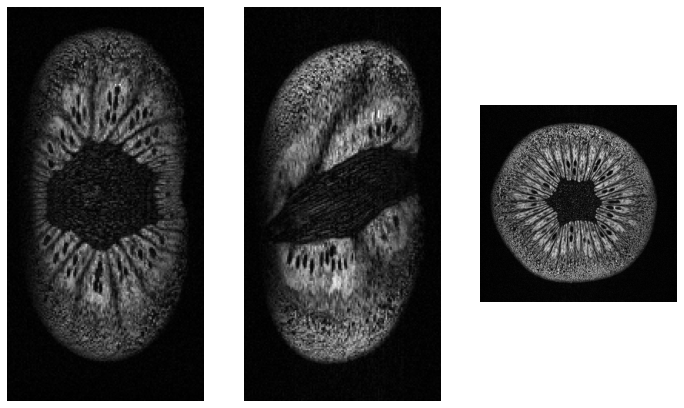

In [14]:
# Let's how our 3D image looks like. 
# We will display the middle slice in each orthogonal view

# get the size in each direction
r, c, s = img3d.shape
r2, c2, s2 = r//2, c//2, s//2
cmap = 'gray'

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ax[0].imshow(img3d[r2,:,:], cmap=cmap)
ax[1].imshow(img3d[:,c2,:], cmap=cmap)
ax[2].imshow(img3d[:,:,s2], cmap=cmap)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

##### YOUR TURN!
1. Visit and browse for the examples and tutorials on the [Matplotlib web page](https://matplotlib.org).
2. Find all avaliable **cmap** and check out how this image looks like with diffrent cmaps.
3. Change parameter of ax[x].axis('off') on 'on' in selected or all graphs. (x is equalled to 1,2,3).
4. See e.g. [here](https://geo-python.github.io/2017/lessons/L4/functions.html).
5. Why we can ommit a 'cmap' parameter during a calling like in the following line:

```python

crossections(im)
```

In [15]:
# As we will display these three cross-sections a few times,
# it will be more convienient to write this piece of code as a function.

def crosssections(im, cmap='gray'):
    """
    Functions shows a middle cross sections of a 3D image.
    
    BMED360v2020
    """
    r, c, s = img3d.shape
    r2, c2, s2 = r//2, c//2, s//2

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
    ax[0].imshow(im[r2,:,:], cmap=cmap)
    ax[1].imshow(im[:,c2,:], cmap=cmap)
    ax[2].imshow(im[:,:,s2], cmap=cmap)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()       

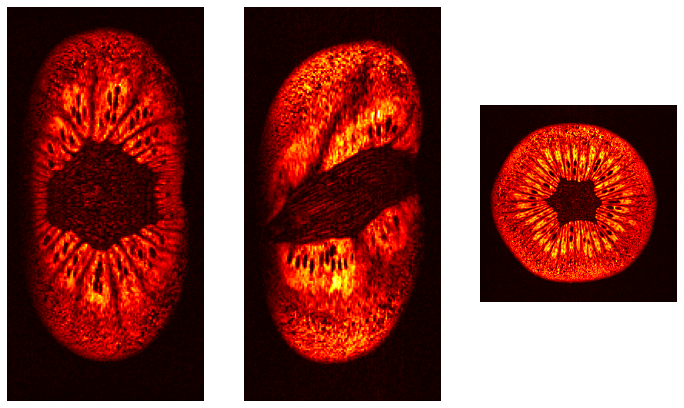

In [16]:
# Let's try our function with different color map
# hot, jet, summer, ....
crosssections(img3d, 'hot')

##### YOUR TURN!
1. Write a function that gets (prints) basic information from a 3D image. It should has the same functionality as the following lines:


```python
print(f'shape: {img3d.shape}') 
print(f'max: {img3d.max()}') # max value in the matrix (3D volume)
print(f'min: {img3d.min()}') # min value int the matrix  
print(f'mean: {img3d.mean():.2f}') # mean value,
print(f'dtype {img3d.dtype}') # type of each pixel (int, float; 8, 16, 32 bits)
```

See e.g. [here](https://geo-python.github.io/2017/lessons/L4/functions.html).

____

#### Image interpolation

In [17]:
# Above images looks "unnaturally". It seems that kiwi is elongated in a vertical direction.
# The reason of this might be a voxel anisotropy during MRI acquisition. 
# Let's check it, we can read the pixes size from the first 2D DICOM image from the set,
# and compare with distance between two conswqutive image slices.
# Pixels within all slices have the same dimensions, and the distance among all slices is equalled.

# pixel shape
xdim, ydim = dcms[0].PixelSpacing
# slice thickness
zdim = dcms[0].SliceThickness
print(f'xdim: {xdim}, ydim: {ydim}, zdim: {zdim}')

xdim: 0.234375, ydim: 0.234375, zdim: 0.5


In [18]:
# To solve this issue, we shoule resample 3D image to isotropoic voxels (each voxel siede has the sdame length)
# Let's asses new voxel thicknes

newzdim = 0.5 / 0.234375
newzdim

2.1333333333333333

In [19]:
# To resample 3D image we can use a handy function from scipy.nidimage package
from scipy import ndimage
img3dres= ndimage.zoom(img3d, [1, 1, newzdim])

In [20]:
# Let's check the image parameters now.

print(f'shape: {img3dres.shape}') 
print(f'max: {img3dres.max()}')
print(f'min: {img3dres.min()}')
print(f'mean: {img3dres.mean():.2f}')
print(f'dtype {img3dres.dtype}') 

shape: (256, 256, 273)
max: 32767
min: -3356
mean: 3386.98
dtype int16


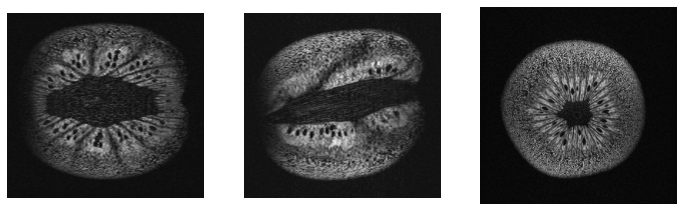

In [21]:
#Let's see how it looks like now
# TODO: WHY WE CAN OMMIT A CMAP PARAMETER DURING CALLING CROSSSECTIONS FUNCTION?
crosssections(img3dres)

##### YOUR TURN!
1. What has changed? Try to describe it. See e.g. [here](http://www.sprawls.org/mripmt/MRI10/index.html).

### Save data (images) to a disk file

Often there is a need to save some (temporary) results to a disk file. As we store our results of calculations (as well as images) in np.ndarray objects (ojbects of numpy package) there is a very easy way to save and load such a results to a file. 

##### Save as a numpy (npy) file

In [22]:
#Let's create a separate folder in which we will store all our results
import os

savefolder = 'kiwi-results'
if not os.path.exists(savefolder):
    os.mkdir(savefolder)
    print(f'"{savefolder}" folder has just been created!')
else:
     print(f'"{savefolder}" folder exists :D')

"kiwi-results" folder exists :D


In [23]:
# Save our new matrix to a disc file. A *\'.npy* is a very handy numpy file format. It is easy to both 
# save and load to/from a disc, what is more these commands store all important matrix fetures like:
# shape, type of the elements in the matrix (dtype).

savefilename = 'kiwi-resampled'
savepath = os.path.join(savefolder, savefilename )
np.save(savepath, img3dres)

In [24]:
# Let's load again saved file to a new variable and check if everything is OK.
# We can use a 'savepath' variable to this purpose

animage = np.load(savepath+'.npy')

##### YOUR TURN!
1. Check all information about loaded image (stored in animage variable) with the use of written function.

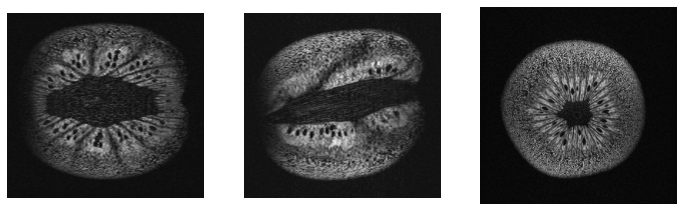

In [25]:
crosssections(animage)

In [26]:
animage.shape

(256, 256, 273)

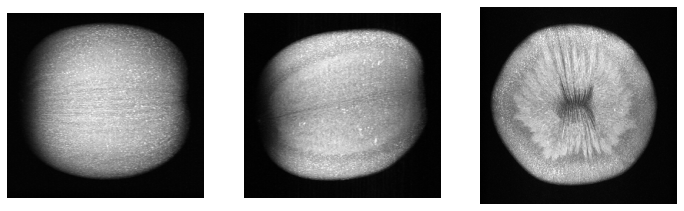

In [27]:
# Let's display Maximum Intensity Projections (MIPs) over an each image direction.

# TODO:
# 1. display images of: minimum intensity function (use min() method)
# 2. write a fuction with the same behaviour

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ax[0].imshow(animage.max(0), cmap=cmap)
ax[1].imshow(animage.max(1), cmap=cmap)
ax[2].imshow(animage.max(2), cmap=cmap)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()   

##### YOUR TURN!
1. Save each cross-section image as a separate png file to a newly created folder (named MIPS).

___

### THRESHOLDING

The simplest method of image segmentation is [thresholding](https://en.wikipedia.org/wiki/Thresholding_(image_processing)). It allows us to separate an image background from foreground (i.e. object of our interest from surrounding background). 

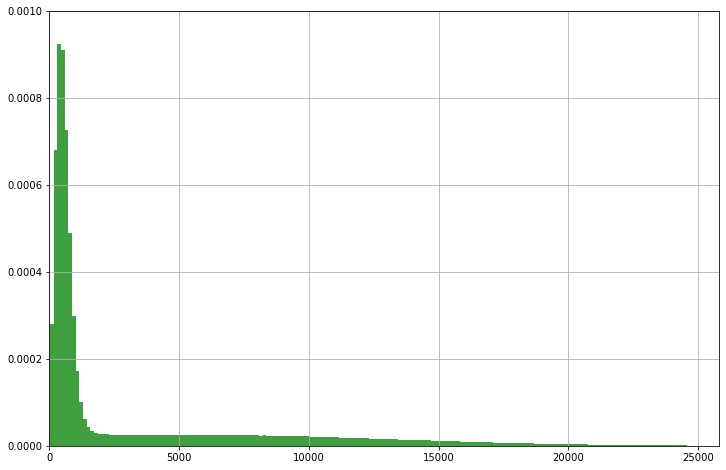

In [28]:
x = img3dres.ravel()
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(x, 256, density=True, facecolor='g', alpha=0.75)
plt.axis([0, 25800, 0, 0.001])
plt.grid(True)

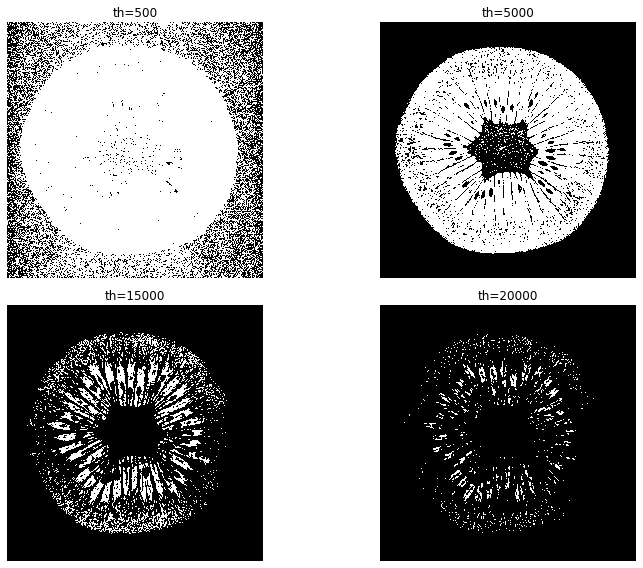

In [29]:
# Let's see how splits image regions for selected thresh values

# select the middle slice
mid = img3dres[:,:,128]

# Set 4 threh values as a list
th = [500, 5000, 15000, 20000]
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for k, a in enumerate(ax.ravel()):
    a.imshow(np.where(mid>th[k],1,0), cmap='gray')
    a.axis('off')
    a.set_title(f'th={str(th[k])}')



plt.tight_layout()
plt.show() 

##### YOUR TURN!

1. Let's try to separate some regions of kiwi. To do this we will plot a [histogram](https://en.wikipedia.org/wiki/Image_histogram) and try to check influecne of thresh values on thresholded imagee.
2. Check the hepl for plt.hist() function from matplotlib package. Change some of avaliable function parameters.
3. Try to explain the shape of histogram we received.
4. Based on histogram shape test a number of thres values and set the best to get the best result.

___

### Selected useful code examples 

#### List comprehension (converts one list in the other list) vs for loop

In [30]:
list1 = [1, 5, 9, 7, 6, 4]
list6 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [31]:
# for loop
list2 = []
for i in list1:
    list2.append(i**2)
print(list2)

# list comprehention
list3 = [f**2 for f in list1]
print(list3)

[1, 25, 81, 49, 36, 16]
[1, 25, 81, 49, 36, 16]


In [32]:
# for loop
list4 = []
for i in list1:
    if i > 5:
        list4.append(i**2)
print(list4)

# # list comprehention
list5 = [f**2 for f in list1  if f>5]
print(list5)

[81, 49, 36]
[81, 49, 36]


In [33]:
list7 = []
for word in list6:
    for letter in word:
        list7.append(letter*3)
print(list7)

['MMM', 'ooo', 'nnn', 'ddd', 'aaa', 'yyy', 'TTT', 'uuu', 'eee', 'sss', 'ddd', 'aaa', 'yyy', 'WWW', 'eee', 'ddd', 'nnn', 'eee', 'sss', 'ddd', 'aaa', 'yyy', 'TTT', 'hhh', 'uuu', 'rrr', 'sss', 'ddd', 'aaa', 'yyy', 'FFF', 'rrr', 'iii', 'ddd', 'aaa', 'yyy', 'SSS', 'aaa', 'ttt', 'uuu', 'rrr', 'ddd', 'aaa', 'yyy', 'SSS', 'uuu', 'nnn', 'ddd', 'aaa', 'yyy']


In [34]:
list8 = [letter*3 for word in list6  for letter in word]
print(list8)

['MMM', 'ooo', 'nnn', 'ddd', 'aaa', 'yyy', 'TTT', 'uuu', 'eee', 'sss', 'ddd', 'aaa', 'yyy', 'WWW', 'eee', 'ddd', 'nnn', 'eee', 'sss', 'ddd', 'aaa', 'yyy', 'TTT', 'hhh', 'uuu', 'rrr', 'sss', 'ddd', 'aaa', 'yyy', 'FFF', 'rrr', 'iii', 'ddd', 'aaa', 'yyy', 'SSS', 'aaa', 'ttt', 'uuu', 'rrr', 'ddd', 'aaa', 'yyy', 'SSS', 'uuu', 'nnn', 'ddd', 'aaa', 'yyy']


___

#### Enumerate

In [35]:
for k, day in enumerate(list6):
    print(f'{k}) {day}')

0) Monday
1) Tuesday
2) Wednesday
3) Thursday
4) Friday
5) Saturday
6) Sunday


___

#### Get specified values from an array

In [36]:
arr = np.array([[1,3,4,6],
                [2,5,7,3],
                [1,9,8,0]])

In [37]:
idx1 = np.where(arr>5)
print(idx1)
arr1 = arr[idx1]
print(arr1)
print(arr1.mean())

(array([0, 1, 2, 2]), array([3, 2, 1, 2]))
[6 7 9 8]
7.5


In [38]:
idx2 = np.nonzero(arr>5)
print(idx2)
arr2 = arr[idx2]
print(arr2)
print(arr2.mean())

(array([0, 1, 2, 2]), array([3, 2, 1, 2]))
[6 7 9 8]
7.5


In [39]:
idx3 = arr>5
print(idx3)
arr3 = arr[arr>5]
print(arr3)
print(arr3.mean())

[[False False False  True]
 [False False  True False]
 [False  True  True False]]
[6 7 9 8]
7.5


___

#### Replace matrix values according to specified value (thresholding)

In [40]:
arr = np.array([[1,3,4,6],
                [2,5,7,3],
                [1,9,8,0]])

In [41]:
arrth=np.where(arr>5,10,0)
arrth

array([[ 0,  0,  0, 10],
       [ 0,  0, 10,  0],
       [ 0, 10, 10,  0]])

___

#### Padding numbers with zeros

In [42]:
i = 1
print(f"{i:0>4}")  # Works for both numbers and strings.
print(f"{i:04}")  # Works only for numbers.

0001
0001


___

#### Matrix creation

In [43]:
a = np.zeros((3,5)); a

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [44]:
b = np.ones((2,3), dtype=np.float32); b

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [45]:
c = np.zeros((3,1), dtype='uint8'); c

array([[0],
       [0],
       [0]], dtype=uint8)

In [46]:
d = np.arange(1, 3, 0.25); d

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75])

In [47]:
e = np.linspace(1, 3, 6); e

array([1. , 1.4, 1.8, 2.2, 2.6, 3. ])

___

##### ravel()

In [48]:
f = np.random.randint(1,100, size=(3,4)); f

array([[41, 61, 41, 62],
       [49, 24, 52, 87],
       [87, 60, 72, 22]])

In [49]:
f.ravel()

array([41, 61, 41, 62, 49, 24, 52, 87, 87, 60, 72, 22])

___

#### Interactive visualization

In [50]:
# It works in ipynb as well as in html files. It is not seen in GitHub.
from nilearn import plotting

/Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



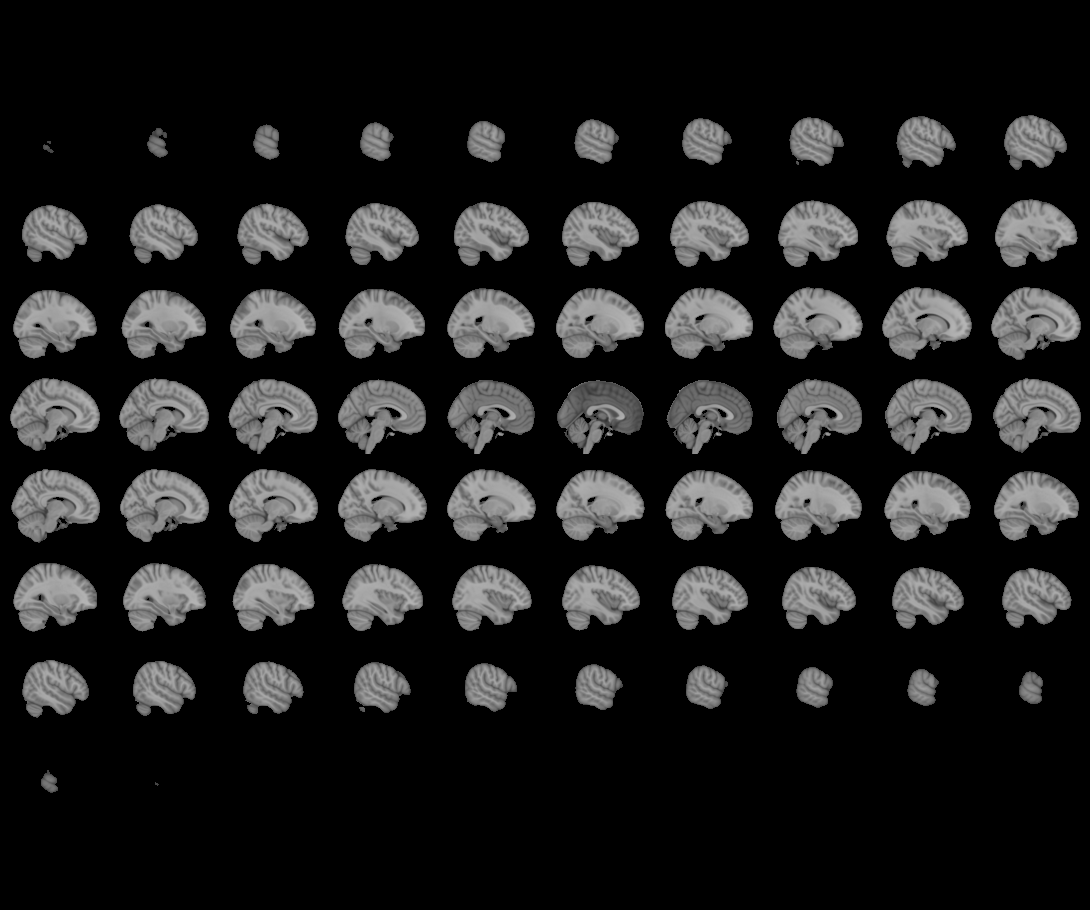
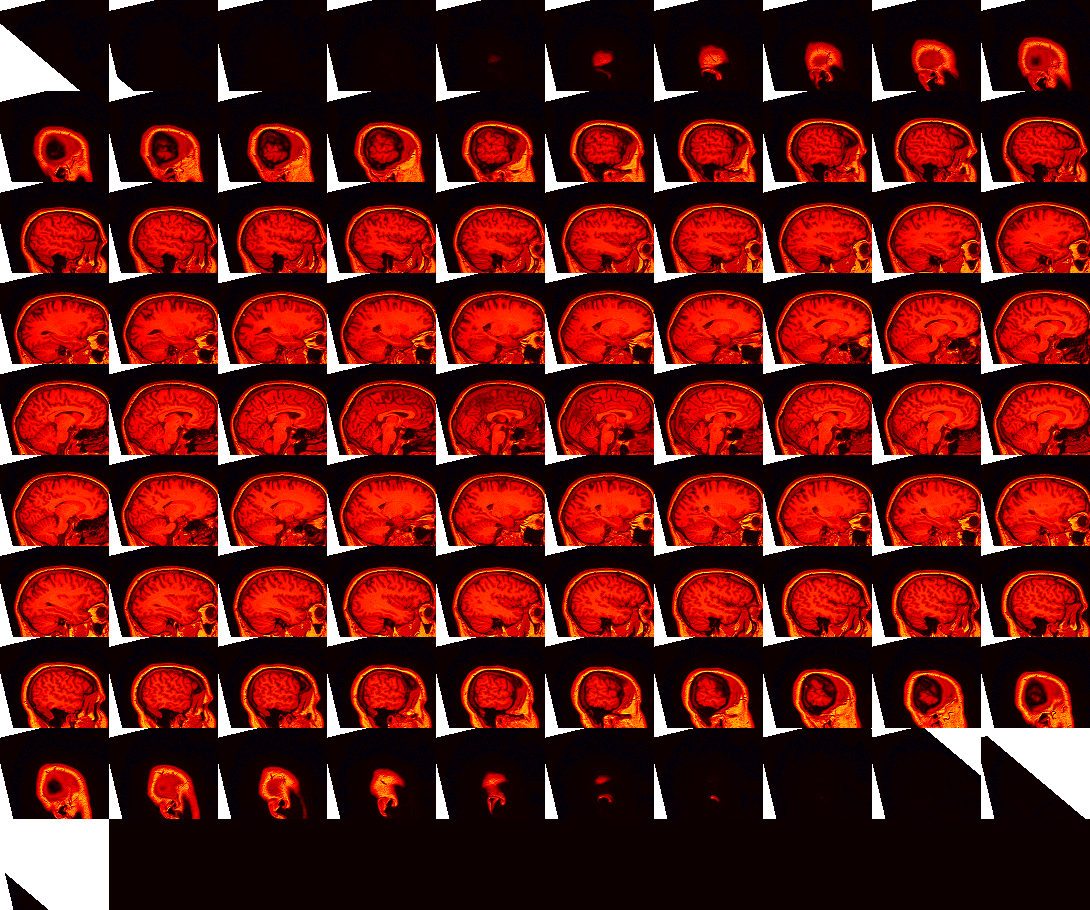

In [51]:
niifile = '../testdata/0.0-test_nifti.nii.gz'

plotting.view_img(niifile, threshold=None)

___